Flower Classification using CNN

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download rahmasleam/flowers-dataset

Dataset URL: https://www.kaggle.com/datasets/rahmasleam/flowers-dataset
License(s): apache-2.0
100% 219M/219M [00:10<00:00, 25.1MB/s]
100% 219M/219M [00:10<00:00, 21.3MB/s]


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [ ]:
import zipfile

zip_path = '/content/flowers-dataset.zip'
extract_dir = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
dataset_path = '/content/flower_photos'

image_paths = []
labels = []

for class_folder in os.listdir(dataset_path):
    class_folder_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_folder_path):
        for img_name in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, img_name)
            image_paths.append(img_path)
            labels.append(class_folder)

In [ ]:
img_size = 224
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, train_size=train_ratio, stratify=labels, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=test_ratio / (test_ratio + val_ratio), stratify=temp_labels, random_state=42
)

In [ ]:
train_df = pd.DataFrame({'filepath': train_paths, 'label': train_labels})
val_df = pd.DataFrame({'filepath': val_paths, 'label': val_labels})
test_df = pd.DataFrame({'filepath': test_paths, 'label': test_labels})

train_df

,filepath,label
0,/content/flower_photos/dandelion/16766166609_c...,dandelion
1,/content/flower_photos/tulips/6970683464_f7083...,tulips
2,/content/flower_photos/sunflowers/265450085_6e...,sunflowers
3,/content/flower_photos/daisy/286875003_f7c0e18...,daisy
4,/content/flower_photos/roses/1801614110_bb9fa4...,roses
...,...,...
2564,/content/flower_photos/roses/568715474_bdb64cc...,roses
2565,/content/flower_photos/sunflowers/4746648726_e...,sunflowers
2566,/content/flower_photos/tulips/4521496161_2b41d...,tulips
2567,/content/flower_photos/sunflowers/200011914_93...,sunflowers


In [ ]:
print("Train shape : ", train_df.shape)
print("Valdation shape : ", val_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (2569, 2)
Valdation shape :  (550, 2)
Test shape :  (551, 2)


In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label', target_size=(img_size, img_size), batch_size=32, class_mode='categorical'
)
val_generator = datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label', target_size=(img_size, img_size), batch_size=32, class_mode='categorical'
)
test_generator = datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label', target_size=(img_size, img_size), batch_size=32, class_mode='categorical', shuffle=False
)

Found 2569 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Found 551 validated image filenames belonging to 5 classes.


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,681,093 (36.93 MB)

 Trainable params: 9,681,093 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=4, validation_data=val_generator)

Epoch 1/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3202 - loss: 1.5294 - val_accuracy: 0.4873 - val_loss: 1.2458
Epoch 2/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.5029 - loss: 1.1640 - val_accuracy: 0.5564 - val_loss: 1.0612
Epoch 3/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6341 - loss: 0.9271 - val_accuracy: 0.6545 - val_loss: 0.9192
Epoch 4/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6914 - loss: 0.8223 - val_accuracy: 0.6418 - val_loss: 0.9327


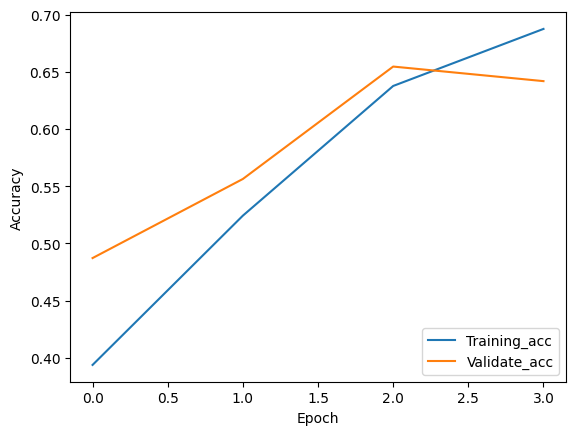

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training_acc', 'Validate_acc'], loc = 'lower right')

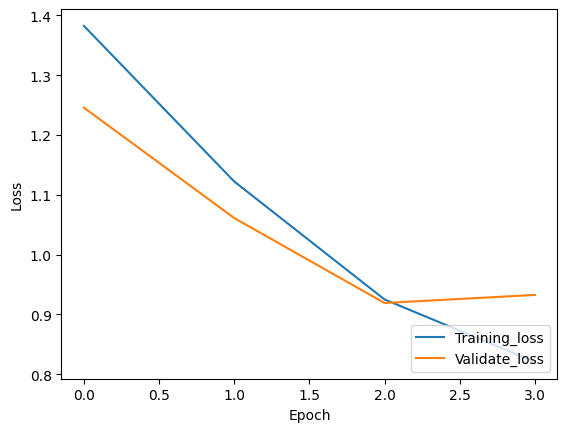

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training_loss', 'Validate_loss'], loc = 'lower right')

In [ ]:
print("Evaluating model on test set:")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Evaluating model on test set:
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6853 - loss: 0.8558
Test Loss: 0.87
Test Accuracy: 0.67


In [ ]:
pred = model.predict(test_generator)
predict_classes = np.argmax(pred, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


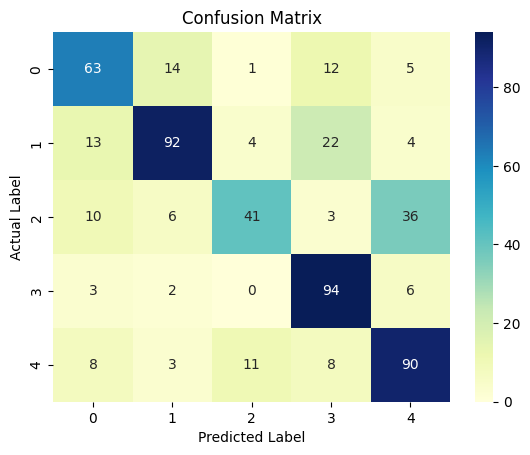

In [ ]:
cm = confusion_matrix(true_classes, predict_classes)
sns.heatmap(cm, annot = True, cmap = "YlGnBu", fmt = "g")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()